# Spark SQL

Spark SQL is arguably one of the most important and powerful features in Spark. This chapter
introduces the core concepts in Spark SQL that you need to understand. This chapter will not
rewrite the ANSI-SQL specification or enumerate every single kind of SQL expression. If you
read any other parts of this book, you will notice that we try to include SQL code wherever we
include DataFrame code to make it easy to cross-reference with code samples. Other examples
are available in the appendix and reference sections.

In a nutshell, with Spark SQL you can run SQL queries against views or tables organized into
databases. You also can use system functions or define user functions and analyze query plans in
order to optimize their workloads. This integrates directly into the DataFrame and Dataset API,
and as we saw in previous chapters, you can choose to express some of your data manipulations
in SQL and others in DataFrames and they will compile to the same underlying code.

## What Is SQL?
SQL or Structured Query Language is a domain-specific language for expressing relational
operations over data. It is used in all relational databases, and many “NoSQL” databases create
their SQL dialect in order to make working with their databases easier. SQL is everywhere, and
even though tech pundits prophesized its death, it is an extremely resilient data tool that many
businesses depend on. Spark implements a subset of ANSI SQL:2003. This SQL standard is one
that is available in the majority of SQL databases and this support means that Spark successfully
runs the popular benchmark TPC-DS.

## Big Data and SQL: Apache Hive
Before Spark’s rise, Hive was the de facto big data SQL access layer. Originally developed at
Facebook, Hive became an incredibly popular tool across industry for performing SQL
operations on big data. In many ways it helped propel Hadoop into different industries because
analysts could run SQL queries. Although Spark began as a general processing engine with
Resilient Distributed Datasets (RDDs), a large cohort of users now use Spark SQL.

## Big Data and SQL: Spark SQL
With the release of Spark 2.0, its authors created a superset of Hive’s support, writing a native
SQL parser that supports both ANSI-SQL as well as HiveQL queries. This, along with its unique
interoperability with DataFrames, makes it a powerful tool for all sorts of companies. For
example, in late 2016, Facebook announced that it had begun running Spark workloads and
seeing large benefits in doing so. In the words of the blog post’s authors:

We challenged Spark to replace a pipeline that decomposed to hundreds of Hive jobs into a
single Spark job. Through a series of performance and reliability improvements, we were able
to scale Spark to handle one of our entity ranking data processing use cases in production….
The Spark-based pipeline produced significant performance improvements (4.5–6x CPU, 3–4x
resource reservation, and ~5x latency) compared with the old Hive-based pipeline, and it has
been running in production for several months.

The power of Spark SQL derives from several key facts: SQL analysts can now take advantage
of Spark’s computation abilities by plugging into the Thrift Server or Spark’s SQL interface,
whereas data engineers and scientists can use Spark SQL where appropriate in any data flow.
This unifying API allows for data to be extracted with SQL, manipulated as a DataFrame, passed
into one of Spark MLlibs’ large-scale machine learning algorithms, written out to another data
source, and everything in between.

___NOTE___

Spark SQL is intended to operate as an online analytic processing (OLAP) database, not an online
transaction processing (OLTP) database. This means that it is not intended to perform extremely lowlatency queries. Even though support for in-place modifications is sure to be something that comes up
in the future, it’s not something that is currently available.

### Spark’s Relationship to Hive
Spark SQL has a great relationship with Hive because it can connect to Hive metastores. The
Hive metastore is the way in which Hive maintains table information for use across sessions.
With Spark SQL, you can connect to your Hive metastore (if you already have one) and access
table metadata to reduce file listing when accessing information. This is popular for users who
are migrating from a legacy Hadoop environment and beginning to run all their workloads using
Spark.

___The Hive metastore___

To connect to the Hive metastore, there are several properties that you’ll need. First, you need to
set the Metastore version (spark.sql.hive.metastore.version) to correspond to the proper
Hive metastore that you’re accessing. By default, this value is 1.2.1. You also need to set
spark.sql.hive.metastore.jars if you’re going to change the way that the
HiveMetastoreClient is initialized. Spark uses the default versions, but you can also specify
Maven repositories or a classpath in the standard format for the Java Virtual Machine (JVM). In
addition, you might need to supply proper class prefixes in order to communicate with different
databases that store the Hive metastore. You’ll set these as shared prefixes that both Spark and
Hive will share (spark.sql.hive.metastore.sharedPrefixes).

If you’re connecting to your own metastore, it’s worth checking the documentation for further
updates and more information.

## How to Run Spark SQL Queries
Spark provides several interfaces to execute SQL queries.
### Spark SQL CLI
The Spark SQL CLI is a convenient tool with which you can make basic Spark SQL queries in
local mode from the command line. Note that the Spark SQL CLI cannot communicate with the
Thrift JDBC server. To start the Spark SQL CLI, run the following in the Spark directory:

./bin/spark-sql

You configure Hive by placing your hive-site.xml, core-site.xml, and hdfs-site.xml files in conf/.
For a complete list of all available options, you can run ./bin/spark-sql --help.
### Spark’s Programmatic SQL Interface
In addition to setting up a server, you can also execute SQL in an ad hoc manner via any of
Spark’s language APIs. You can do this via the method sql on the SparkSession object. This
returns a DataFrame, as we will see later in this chapter. For example, in Python or Scala, we can
run the following:
~~~
spark.sql("SELECT 1 + 1").show()
~~~
The command spark.sql("SELECT 1 + 1") returns a DataFrame that we can then evaluate
programmatically. Just like other transformations, this will not be executed eagerly but lazily.
This is an immensely powerful interface because there are some transformations that are much
simpler to express in SQL code than in DataFrames.
You can express multiline queries quite simply by passing a multiline string into the function.
For example, you could execute something like the following code in Python or Scala:
~~~
spark.sql("""SELECT user_id, department, first_name FROM professors
WHERE department IN
(SELECT name FROM department WHERE created_date >= '2016-01-01')""")
~~~
Even more powerful, you can completely interoperate between SQL and DataFrames, as you see
fit. For instance, you can create a DataFrame, manipulate it with SQL, and then manipulate it
again as a DataFrame. It’s a powerful abstraction that you will likely find yourself using quite a
bit:
~~~
// in Scala
spark.read.json("/data/flight-data/json/2015-summary.json")
.createOrReplaceTempView("some_sql_view") // DF => SQL
spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count)
FROM some_sql_view GROUP BY DEST_COUNTRY_NAME
""")
.where("DEST_COUNTRY_NAME like 'S%'").where("`sum(count)` > 10")
.count() // SQL => DF
# in Python
spark.read.json("/data/flight-data/json/2015-summary.json")\
.createOrReplaceTempView("some_sql_view") # DF => SQL
spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count)
FROM some_sql_view GROUP BY DEST_COUNTRY_NAME
""")\
.where("DEST_COUNTRY_NAME like 'S%'").where("`sum(count)` > 10")\
.count() # SQL => DF
~~~
### SparkSQL Thrift JDBC/ODBC Server
Spark provides a Java Database Connectivity (JDBC) interface by which either you or a remote
program connects to the Spark driver in order to execute Spark SQL queries. A common use case
might be a for a business analyst to connect business intelligence software like Tableau to Spark.
The Thrift JDBC/Open Database Connectivity (ODBC) server implemented here corresponds to
the HiveServer2 in Hive 1.2.1. You can test the JDBC server with the beeline script that comes
with either Spark or Hive 1.2.1.

To start the JDBC/ODBC server, run the following in the Spark directory:

./sbin/start-thriftserver.sh

This script accepts all bin/spark-submit command-line options. To see all available options
for configuring this Thrift Server, run ./sbin/start-thriftserver.sh --help. By default,
the server listens on localhost:10000. You can override this through environmental variables or
system properties.

For environment configuration, use this:
~~~
export HIVE_SERVER2_THRIFT_PORT=<listening-port>
export HIVE_SERVER2_THRIFT_BIND_HOST=<listening-host>
./sbin/start-thriftserver.sh \
--master <master-uri> \
...
~~~
For system properties:
~~~
./sbin/start-thriftserver.sh \
--hiveconf hive.server2.thrift.port=<listening-port> \
--hiveconf hive.server2.thrift.bind.host=<listening-host> \
--master <master-uri>
...
~~~
You can then test this connection by running the following commands:
~~~
./bin/beeline
beeline> !connect jdbc:hive2://localhost:10000
~~~
Beeline will ask you for a username and password. In nonsecure mode, simply type the username
on your machine and a blank password. For secure mode, follow the instructions given in the
beeline documentation.

## Catalog
The highest level abstraction in Spark SQL is the Catalog. The Catalog is an abstraction for the
storage of metadata about the data stored in your tables as well as other helpful things like
databases, tables, functions, and views. The catalog is available in the
org.apache.spark.sql.catalog.Catalog package and contains a number of helpful functions
for doing things like listing tables, databases, and functions. We will talk about all of these things
shortly. It’s very self-explanatory to users, so we will omit the code samples here but it’s really
just another programmatic interface to Spark SQL. This chapter shows only the SQL being
executed; thus, if you’re using the programmatic interface, keep in mind that you need to wrap
everything in a spark.sql function call to execute the relevant code.

## Tables
To do anything useful with Spark SQL, you first need to define tables. Tables are logically
equivalent to a DataFrame in that they are a structure of data against which you run commands.
We can join tables, filter them, aggregate them, and perform different manipulations that we saw
in previous chapters. The core difference between tables and DataFrames is this: you define
DataFrames in the scope of a programming language, whereas you define tables within a
database. This means that when you create a table (assuming you never changed the database), it
will belong to the default database. We discuss databases more fully later on in the chapter.
An important thing to note is that in Spark 2.X, tables always contain data. There is no notion of
a temporary table, only a view, which does not contain data. This is important because if you go
to drop a table, you can risk losing the data when doing so.

### Spark-Managed Tables
One important note is the concept of managed versus unmanaged tables. Tables store two
important pieces of information. The data within the tables as well as the data about the tables;
that is, the metadata. You can have Spark manage the metadata for a set of files as well as for the
data. When you define a table from files on disk, you are defining an unmanaged table. When
you use saveAsTable on a DataFrame, you are creating a managed table for which Spark will
track of all of the relevant information.

This will read your table and write it out to a new location in Spark format. You can see this
reflected in the new explain plan. In the explain plan, you will also notice that this writes to the
default Hive warehouse location. You can set this by setting the spark.sql.warehouse.dir
configuration to the directory of your choosing when you create your SparkSession. By default
Spark sets this to /user/hive/warehouse:

Note in the results that a database is listed. Spark also has databases which we will discuss later
in this chapter, but for now you should keep in mind that you can also see tables in a specific
database by using the query show tables IN databaseName, where databaseName represents
the name of the database that you want to query.

If you are running on a new cluster or local mode, this should return zero results.

### Creating Tables
You can create tables from a variety of sources. Something fairly unique to Spark is the
capability of reusing the entire Data Source API within SQL. This means that you do not need to
define a table and then load data into it; Spark lets you create one on the fly. You can even
specify all sorts of sophisticated options when you read in a file. For example, here’s a simple
way to read in the flight data we worked with in previous chapters:
~~~
CREATE TABLE flights (
DEST_COUNTRY_NAME STRING, ORIGIN_COUNTRY_NAME STRING, count LONG)
USING JSON OPTIONS (path '/data/flight-data/json/2015-summary.json')
~~~
___USING AND STORED AS___

The specification of the USING syntax in the previous example is of significant importance. If
you do not specify the format, Spark will default to a Hive SerDe configuration. This has
performance implications for future readers and writers because Hive SerDes are much
slower than Spark’s native serialization. Hive users can also use the STORED AS syntax to
specify that this should be a Hive table.

You can also add comments to certain columns in a table, which can help other developers
understand the data in the tables:
~~~
CREATE TABLE flights_csv (
DEST_COUNTRY_NAME STRING,
ORIGIN_COUNTRY_NAME STRING COMMENT "remember, the US will be most prevalent",
count LONG)
USING csv OPTIONS (header true, path '/data/flight-data/csv/2015-summary.csv')
~~~
It is possible to create a table from a query as well:
~~~
CREATE TABLE flights_from_select USING parquet AS SELECT * FROM flights
~~~
In addition, you can specify to create a table only if it does not currently exist:

___NOTE___

In this example, we are creating a Hive-compatible table because we did not explicitly specify the
format via USING. We can also do the following:
~~~
CREATE TABLE IF NOT EXISTS flights_from_select
AS SELECT * FROM flights
~~~
Finally, you can control the layout of the data by writing out a partitioned dataset, as we saw in
Chapter 9:
~~~
CREATE TABLE partitioned_flights USING parquet PARTITIONED BY (DEST_COUNTRY_NAME)
AS SELECT DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME, count FROM flights LIMIT 5
~~~
These tables will be available in Spark even through sessions; temporary tables do not currently
exist in Spark. You must create a temporary view, which we demonstrate later in this chapter.

### Creating External Tables
As we mentioned in the beginning of this chapter, Hive was one of the first big data SQL
systems, and Spark SQL is completely compatible with Hive SQL (HiveQL) statements. One of
the use cases that you might encounter is to port your legacy Hive statements to Spark SQL.
Luckily, you can, for the most part, just copy and paste your Hive statements directly into Spark
SQL. For example, in the example that follows, we create an unmanaged table. Spark will
manage the table’s metadata; however, the files are not managed by Spark at all. You create this
table by using the CREATE EXTERNAL TABLE statement.

You can view any files that have already been defined by running the following command:
~~~
CREATE EXTERNAL TABLE hive_flights (
DEST_COUNTRY_NAME STRING, ORIGIN_COUNTRY_NAME STRING, count LONG)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LOCATION '/data/flight-data-hive/'
~~~
You can also create an external table from a select clause:
~~~
CREATE EXTERNAL TABLE hive_flights_2
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
LOCATION '/data/flight-data-hive/' AS SELECT * FROM flights
~~~

### Inserting into Tables
Insertions follow the standard SQL syntax:
~~~
INSERT INTO flights_from_select
SELECT DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME, count FROM flights LIMIT 20
~~~
You can optionally provide a partition specification if you want to write only into a certain
partition. Note that a write will respect a partitioning scheme, as well (which may cause the
above query to run quite slowly); however, it will add additional files only into the end
partitions:
~~~
INSERT INTO partitioned_flights
PARTITION (DEST_COUNTRY_NAME="UNITED STATES")
SELECT count, ORIGIN_COUNTRY_NAME FROM flights
WHERE DEST_COUNTRY_NAME='UNITED STATES' LIMIT 12
~~~

### Describing Table Metadata
We saw earlier that you can add a comment when creating a table. You can view this by
describing the table metadata, which will show us the relevant comment:
~~~
DESCRIBE TABLE flights_csv
~~~
You can also see the partitioning scheme for the data by using the following (note, however, that
this works only on partitioned tables):
~~~
SHOW PARTITIONS partitioned_flights
~~~

### Refreshing Table Metadata
Maintaining table metadata is an important task to ensure that you’re reading from the most
recent set of data. There are two commands to refresh table metadata. REFRESH TABLE refreshes
all cached entries (essentially, files) associated with the table. If the table were previously
cached, it would be cached lazily the next time it is scanned:
~~~
REFRESH table partitioned_flights
~~~
Another related command is REPAIR TABLE, which refreshes the partitions maintained in the
catalog for that given table. This command’s focus is on collecting new partition information—
an example might be writing out a new partition manually and the need to repair the table
accordingly:
~~~
MSCK REPAIR TABLE partitioned_flights
~~~

### Dropping Tables
You cannot delete tables: you can only “drop” them. You can drop a table by using the DROP
keyword. If you drop a managed table (e.g., flights_csv), both the data and the table definition
will be removed:
~~~
DROP TABLE flights_csv;
~~~
___WARNING___

Dropping a table deletes the data in the table, so you need to be very careful when doing this.

If you try to drop a table that does not exist, you will receive an error. To only delete a table if it
already exists, use DROP TABLE IF EXISTS.
~~~
DROP TABLE IF EXISTS flights_csv;
~~~
___WARNING___

This deletes the data in the table, so exercise caution when doing this.

___Dropping unmanaged tables___

If you are dropping an unmanaged table (e.g., hive_flights), no data will be removed but you
will no longer be able to refer to this data by the table name.

### Caching Tables
Just like DataFrames, you can cache and uncache tables. You simply specify which table you
would like using the following syntax:
~~~
CACHE TABLE flights
~~~
Here’s how you uncache them:
~~~
UNCACHE TABLE FLIGHTS
~~~

## Views
Now that you created a table, another thing that you can define is a view. A view specifies a set
of transformations on top of an existing table—basically just saved query plans, which can be
convenient for organizing or reusing your query logic. Spark has several different notions of
views. Views can be global, set to a database, or per session.
### Creating Views
To an end user, views are displayed as tables, except rather than rewriting all of the data to a new
location, they simply perform a transformation on the source data at query time. This might be a
filter, select, or potentially an even larger GROUP BY or ROLLUP. For instance, in the
following example, we create a view in which the destination is United States in order to see
only those flights:
~~~
CREATE VIEW just_usa_view AS
SELECT * FROM flights WHERE dest_country_name = 'United States'
~~~
Like tables, you can create temporary views that are available only during the current session and
are not registered to a database:
~~~
CREATE TEMP VIEW just_usa_view_temp AS
SELECT * FROM flights WHERE dest_country_name = 'United States'
~~~
Or, it can be a global temp view. Global temp views are resolved regardless of database and are
viewable across the entire Spark application, but they are removed at the end of the session:
~~~
CREATE GLOBAL TEMP VIEW just_usa_global_view_temp AS
SELECT * FROM flights WHERE dest_country_name = 'United States'
SHOW TABLES
~~~
You can also specify that you would like to overwite a view if one already exists by using the
keywords shown in the sample that follows. We can overwrite both temp views and regular
views:
~~~
CREATE OR REPLACE TEMP VIEW just_usa_view_temp AS
SELECT * FROM flights WHERE dest_country_name = 'United States'
~~~
Now you can query this view just as if it were another table:
~~~
SELECT * FROM just_usa_view_temp
~~~
A view is effectively a transformation and Spark will perform it only at query time. This means
that it will only apply that filter after you actually go to query the table (and not earlier).
Effectively, views are equivalent to creating a new DataFrame from an existing DataFrame.

In fact, you can see this by comparing the query plans generated by Spark DataFrames and Spark
SQL. In DataFrames, we would write the following:
~~~
val flights = spark.read.format("json")
.load("/data/flight-data/json/2015-summary.json")
val just_usa_df = flights.where("dest_country_name = 'United States'")
just_usa_df.selectExpr("*").explain
~~~
In SQL, we would write (querying from our view) this:
~~~
EXPLAIN SELECT * FROM just_usa_view
~~~
Or, equivalently:
~~~
EXPLAIN SELECT * FROM flights WHERE dest_country_name = 'United States'
~~~
Due to this fact, you should feel comfortable in writing your logic either on DataFrames or SQL —whichever is most comfortable and maintainable for you.
### Dropping Views
You can drop views in the same way that you drop tables; you simply specify that what you
intend to drop is a view instead of a table. The main difference between dropping a view and
dropping a table is that with a view, no underlying data is removed, only the view definition
itself:
~~~
DROP VIEW IF EXISTS just_usa_view;
~~~

## Databases
Databases are a tool for organizing tables. As mentioned earlier, if you do not define one, Spark
will use the default database. Any SQL statements that you run from within Spark (including
DataFrame commands) execute within the context of a database. This means that if you change
the database, any user-defined tables will remain in the previous database and will need to be
queried differently.

___WARNING___
This can be a source of confusion, especially if you’re sharing the same context or session for your
coworkers, so be sure to set your databases appropriately.

You can see all databases by using the following command:
~~~
SHOW DATABASES
~~~
### Creating Databases
Creating databases follows the same patterns you’ve seen previously in this chapter; however,
here you use the CREATE DATABASE keywords:
~~~
CREATE DATABASE some_db
~~~
### Setting the Database
You might want to set a database to perform a certain query. To do this, use the USE keyword
followed by the database name:
~~~
USE some_db
~~~
After you set this database, all queries will try to resolve table names to this database. Queries
that were working just fine might now fail or yield different results because you are in a different
database:
~~~
SHOW tables
SELECT * FROM flights -- fails with table/view not found
~~~
However, you can query different databases by using the correct prefix:
~~~
SELECT * FROM default.flights
~~~
You can see what database you’re currently using by running the following command:
~~~
SELECT current_database()
~~~
You can, of course, switch back to the default database:
~~~
USE default;
~~~
### Dropping Databases
Dropping or removing databases is equally as easy: you simply use the DROP DATABASE
keyword:
~~~
DROP DATABASE IF EXISTS some_db;
~~~

## Select Statements
Queries in Spark support the following ANSI SQL requirements (here we list the layout of the
SELECT expression):
~~~
SELECT [ALL|DISTINCT] named_expression[, named_expression, ...]
FROM relation[, relation, ...]
[lateral_view[, lateral_view, ...]]
[WHERE boolean_expression]
[aggregation [HAVING boolean_expression]]
[ORDER BY sort_expressions]
[CLUSTER BY expressions]
[DISTRIBUTE BY expressions]
[SORT BY sort_expressions]
[WINDOW named_window[, WINDOW named_window, ...]]
[LIMIT num_rows]
named_expression:
: expression [AS alias]
relation:
| join_relation
| (table_name|query|relation) [sample] [AS alias]
: VALUES (expressions)[, (expressions), ...]
[AS (column_name[, column_name, ...])]
expressions:
: expression[, expression, ...]
sort_expressions:
: expression [ASC|DESC][, expression [ASC|DESC], ...]
~~~
### case…when…then Statements
Oftentimes, you might need to conditionally replace values in your SQL queries. You can do this
by using a case...when...then...end style statement. This is essentially the equivalent of
programmatic if statements:
~~~
SELECT
CASE WHEN DEST_COUNTRY_NAME = 'UNITED STATES' THEN 1
WHEN DEST_COUNTRY_NAME = 'Egypt' THEN 0
ELSE -1 END
FROM partitioned_flights
~~~

## Advanced Topics
Now that we defined where data lives and how to organize it, let’s move on to querying it. A
SQL query is a SQL statement requesting that some set of commands be run. SQL statements
can define manipulations, definitions, or controls. The most common case are the manipulations,
which is the focus of this book.
### Complex Types
Complex types are a departure from standard SQL and are an incredibly powerful feature that
does not exist in standard SQL. Understanding how to manipulate them appropriately in SQL is
essential. There are three core complex types in Spark SQL: structs, lists, and maps.

___Structs___

Structs are more akin to maps. They provide a way of creating or querying nested data in Spark.
To create one, you simply need to wrap a set of columns (or expressions) in parentheses:
~~~
CREATE VIEW IF NOT EXISTS nested_data AS
SELECT (DEST_COUNTRY_NAME, ORIGIN_COUNTRY_NAME) as country, count FROM flights
~~~
Now, you can query this data to see what it looks like:
~~~
SELECT * FROM nested_data
~~~
You can even query individual columns within a struct—all you need to do is use dot syntax:
~~~
SELECT country.DEST_COUNTRY_NAME, count FROM nested_data
~~~
If you like, you can also select all the subvalues from a struct by using the struct’s name and
select all of the subcolumns. Although these aren’t truly subcolumns, it does provide a simpler
way to think about them because we can do everything that we like with them as if they were a
column:
~~~
SELECT country.*, count FROM nested_data
~~~
___Lists___

If you’re familiar with lists in programming languages, Spark SQL lists will feel familiar. There
are several ways to create an array or list of values. You can use the collect_list function,
which creates a list of values. You can also use the function collect_set, which creates an
array without duplicate values. These are both aggregation functions and therefore can be
specified only in aggregations:
~~~
SELECT DEST_COUNTRY_NAME as new_name, collect_list(count) as flight_counts,
collect_set(ORIGIN_COUNTRY_NAME) as origin_set
FROM flights GROUP BY DEST_COUNTRY_NAME
~~~
You can, however, also create an array manually within a column, as shown here:
~~~
SELECT DEST_COUNTRY_NAME, ARRAY(1, 2, 3) FROM flights
~~~
You can also query lists by position by using a Python-like array query syntax:
~~~
SELECT DEST_COUNTRY_NAME as new_name, collect_list(count)[0]
FROM flights GROUP BY DEST_COUNTRY_NAME
~~~
You can also do things like convert an array back into rows. You do this by using the explode
function. To demonstrate, let’s create a new view as our aggregation:
~~~
CREATE OR REPLACE TEMP VIEW flights_agg AS
SELECT DEST_COUNTRY_NAME, collect_list(count) as collected_counts
FROM flights GROUP BY DEST_COUNTRY_NAME
~~~
Now let’s explode the complex type to one row in our result for every value in the array. The
DEST_COUNTRY_NAME will duplicate for every value in the array, performing the exact opposite of
the original collect and returning us to the original DataFrame:
~~~
SELECT explode(collected_counts), DEST_COUNTRY_NAME FROM flights_agg
~~~
### Functions
In addition to complex types, Spark SQL provides a variety of sophisticated functions. You can
find most of these functions in the DataFrames function reference; however, it is worth
understanding how to find these functions in SQL, as well. To see a list of functions in Spark
SQL, you use the SHOW FUNCTIONS statement:
~~~
SHOW FUNCTIONS
~~~
You can also more specifically indicate whether you would like to see the system functions (i.e.,
those built into Spark) as well as user functions:
~~~
SHOW SYSTEM FUNCTIONS
~~~
User functions are those defined by you or someone else sharing your Spark environment. These
are the same user-defined functions that we talked about in earlier chapters (we will discuss how
to create them later on in this chapter):
~~~
SHOW USER FUNCTIONS
~~~
You can filter all SHOW commands by passing a string with wildcard (*) characters. Here, we can
see all functions that begin with “s”:
~~~
SHOW FUNCTIONS "s*";
~~~
Optionally, you can include the LIKE keyword, although this is not necessary:
~~~
SHOW FUNCTIONS LIKE "collect*";
~~~
Even though listing functions is certainly useful, often you might want to know more about
specific functions themselves. To do this, use the DESCRIBE keyword, which returns the
documentation for a specific function.

___User-defined functions___

As we saw in Chapters 3 and 4, Spark gives you the ability to define your own functions and use
them in a distributed manner. You can define functions, just as you did before, writing the
function in the language of your choice and then registering it appropriately:
~~~
def power3(number:Double):Double = number * number * number
spark.udf.register("power3", power3(_:Double):Double)
SELECT count, power3(count) FROM flights
~~~
You can also register functions through the Hive CREATE TEMPORARY FUNCTION syntax.
### Subqueries
With subqueries, you can specify queries within other queries. This makes it possible for you to
specify some sophisticated logic within your SQL. In Spark, there are two fundamental
subqueries. Correlated subqueries use some information from the outer scope of the query in
order to supplement information in the subquery. Uncorrelated subqueries include no
information from the outer scope. Each of these queries can return one (scalar subquery) or more
values. Spark also includes support for predicate subqueries, which allow for filtering based on
values.

___Uncorrelated predicate subqueries___

For example, let’s take a look at a predicate subquery. In this example, this is composed of two
uncorrelated queries. The first query is just to get the top five country destinations based on the
data we have:
~~~
SELECT dest_country_name FROM flights
GROUP BY dest_country_name ORDER BY sum(count) DESC LIMIT 5
This gives us the following result:
+-----------------+
|dest_country_name|
+-----------------+
| United States|
| Canada|
| Mexico|
| United Kingdom|
| Japan|
+-----------------+
~~~
Now we place this subquery inside of the filter and check to see if our origin country exists in
that list:
~~~
SELECT * FROM flights
WHERE origin_country_name IN (SELECT dest_country_name FROM flights
GROUP BY dest_country_name ORDER BY sum(count) DESC LIMIT 5)
~~~
This query is uncorrelated because it does not include any information from the outer scope of
the query. It’s a query that you can run on its own.

___Correlated predicate subqueries__

Correlated predicate subqueries allow you to use information from the outer scope in your inner
query. For example, if you want to see whether you have a flight that will take you back from
your destination country, you could do so by checking whether there is a flight that has the
destination country as an origin and a flight that had the origin country as a destination:
~~~
SELECT * FROM flights f1
WHERE EXISTS (SELECT 1 FROM flights f2
WHERE f1.dest_country_name = f2.origin_country_name)
AND EXISTS (SELECT 1 FROM flights f2
WHERE f2.dest_country_name = f1.origin_country_name)
~~~
___EXISTS___ just checks for some existence in the subquery and returns true if there is a value. You
can flip this by placing the NOT operator in front of it. This would be equivalent to finding a flight
to a destination from which you won’t be able to return!

___Uncorrelated scalar queries___

Using uncorrelated scalar queries, you can bring in some supplemental information that you
might not have previously. For example, if you wanted to include the maximum value as its own
column from the entire counts dataset, you could do this:
~~~
SELECT *, (SELECT max(count) FROM flights) AS maximum FROM flights
~~~


## Miscellaneous Features
There are some features in Spark SQL that don’t quite fit in previous sections of this chapter, so
we’re going to include them here in no particular order. These can be relevant when performing
optimizations or debugging your SQL code.
### Configurations
There are several Spark SQL application configurations, which we list in Table 10-1. You can set
these either at application initialization or over the course of application execution (like we have
seen with shuffle partitions throughout this book).
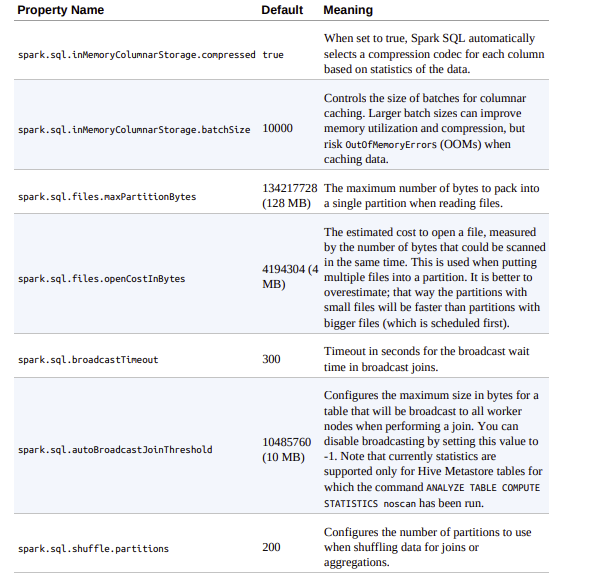
### Setting Configuration Values in SQL
We talk about configurations in Chapter 15, but as a preview, it’s worth mentioning how to set
configurations from SQL. Naturally, you can only set Spark SQL configurations that way, but
here’s how you can set shuffle partitions:
~~~
SET spark.sql.shuffle.partitions=20
~~~

## Conclusion
It should be clear from this chapter that Spark SQL and DataFrames are very closely related and
that you should be able to use nearly all of the examples throughout this book with only small
syntactical tweaks. This chapter illustrated more of the Spark SQL–related specifics. Chapter 11
focuses on a new concept: Datasets that allow for type-safe structured transformations.